In [1]:
import os
import time
import sys
import scipy
import glob
import importlib

import pandas as pd
import numpy as np

import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

from datetime import datetime

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil

In [2]:
from pathlib import Path
import tifffile as tf
import re
import cv2

In [3]:
util.set_sns_style(style='dark')
%matplotlib notebook

In [4]:
rootdir = '/Volumes/Julie/plume-tracking'

experiment = 'stripgrid'
session = '20221102'

src_dir = os.path.join(rootdir, session, 'raw')

# create fig ID
fig_id = os.path.join(experiment, session)
print("Fig ID: {}".format(fig_id))
# Create output dir for figures
dst_dir = os.path.join(rootdir, session, 'processed')

print("Saving figures to:{}    {}".format('\n', dst_dir))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

Fig ID: stripgrid/20221102
Saving figures to:
    /Volumes/Julie/plume-tracking/20221102/processed


In [9]:
fly_id = 'fly3'
# check if anatomicals
# anat_dirs = glob.glob(os.path.join(src_dir, '*{}_anatomical*'.format(fly_id)))
anat_fns = glob.glob(os.path.join(src_dir, '*{}_anatomical*.tif'.format(fly_id)))
print("Found {} anatomical paths".format(len(anat_fns)))

# check if functionals
func_paths = glob.glob(os.path.join(src_dir, '*{}_{}*'.format(fly_id, experiment)))
#func_paths
# imdirs = sorted([p for p in func_fns if Path(p).is_dir()], key=util.natsort)
tf_fns = sorted([p for p in func_paths if p.endswith('.tif')])
ft_fns = sorted([p for p in func_paths if p.endswith('.log')])
assert len(ft_fns)==len(tf_fns), \
"Incorrect fictrac files (n={}) and tif files (n={})".format(len(ft_fns), len(tf_fns))
print("Found {} functional runs".format(len(tf_fns)))

Found 1 anatomical paths


AssertionError: Incorrect fictrac files (n=2) and tif files (n=1)

In [6]:
filedict={}
for fi, (imdir, ftfn) in enumerate(zip(imdirs, ftfns)):
    imfns = sorted(glob.glob(os.path.join(imdir, '*.tif')), key=util.natsort)
    datestr_2p = datetime.fromtimestamp(os.path.getmtime(imfns[0])).strftime('%Y%M%d-%H%M%S')
    datestr_ft = datetime.fromtimestamp(os.path.getmtime(ftfn)).strftime('%Y%M%d-%H%M%S')
    filedict.update({fi: {'image_dir': imdir, 
                          'ft_fpath': ftfn,
                          'ft_tstamp': datestr_ft,
                          'im_tstamp': datestr_2p}})
filedict

{0: {'image_dir': '/Volumes/Julie/plume-tracking/20221102/raw/TSeries-11022022-1740_hdc-split-sytGCaMP7f-60D05_fly3_stripgrid-001',
  'ft_fpath': '/Volumes/Julie/plume-tracking/20221102/raw/11022022-174454_hdc-sytGCaMP7f_fly3_stripgrid_2p.log',
  'ft_tstamp': '20220002-180013',
  'im_tstamp': '20220202-180216'},
 1: {'image_dir': '/Volumes/Julie/plume-tracking/20221102/raw/TSeries-11022022-1740_hdc-split-sytGCaMP7f-60D05_fly3_stripgrid-002',
  'ft_fpath': '/Volumes/Julie/plume-tracking/20221102/raw/11022022-180758_hdc-sytGCaMP7f_fly3_stripgrid_2p.log',
  'ft_tstamp': '20221402-181443',
  'im_tstamp': '20221502-181548'}}

## view anatomical

In [7]:
anat_src = anat_dirs[0]
anat_fns = sorted(glob.glob(os.path.join(anat_src, '*.tif')), key=util.natsort)
len(anat_fns)

2500

In [14]:
# %timeit imstack = np.dstack([cv2.imread(i, -1) for i in curr_ims])

3.86 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
# nslices = 25
# nreps = 100
# stack_=[]
# for i in range(nslices):
#     curr_ims = [f for f in anat_fns if re.search('_{:06d}'.format(i+1), f)]
#     assert len(curr_ims)==nreps, "Found {} reps, expecting {}".format(len(curr_ims), nreps)
#     imstack = np.dstack([cv2.imread(i, -1) for i in curr_ims]) # (h x w x z)
#     #imstack1 = np.swapaxes(np.swapaxes(imstack, 0, 2), 1, 2) # swap axes to be standard tif
#     #mean_im = imstack1.mean(axis=0)
#     stack_.append(imstack)

In [58]:
fullstack = np.dstack([cv2.imread(i, -1) for i in anat_fns])

fullstack1 = np.swapaxes(np.swapaxes(fullstack, 0, 2), 1, 2)
fullstack1.shape


In [54]:
fullstack = np.dstack(stack_)
fullstack1 = np.swapaxes(np.swapaxes(fullstack, 0, 2), 1, 2)


In [55]:
fullstack1.shape

(2500, 110, 89)

In [63]:
fname = '{}_test.tif'.format(os.path.split(anat_src)[-1])
fname

'TSeries-11022022-1740_hdc-split-sytGCaMP7f-60D05_fly3_anatomical-001_test.tif'

In [64]:
outfn = os.path.join(src_dir, fname)
tf.imwrite(outfn, fullstack1)

In [67]:
outfn = os.path.join(src_dir, fname)
cv2.imwrite(outfn, fullstack1)

error: OpenCV(4.6.0) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:737: error: (-215:Assertion failed) image.channels() == 1 || image.channels() == 3 || image.channels() == 4 in function 'imwrite_'


In [69]:
fullstack1.dtype

dtype('uint16')

In [27]:
import shutil

In [28]:
xml_fns = glob.glob(os.path.join(anat_src, '*.xml'))
for f in xml_fns:
    parentdir = os.path.split(anat_src)[0]
    fname = os.path.split(f)[-1]
    shutil.move(f, os.path.join(parentdir, fname))

In [35]:
tifstacks = glob.glob(os.path.join(src_dir, '*.tif'))
tifstacks

['/Volumes/Julie/plume-tracking/20221102/raw/TSeries-11022022-1740_hdc-split-sytGCaMP7f-60D05_fly3_anatomical-001.tif',
 '/Volumes/Julie/plume-tracking/20221102/raw/TSeries-11022022-1740_hdc-split-sytGCaMP7f-60D05_fly3_stripgrid-001.tif']

In [36]:
tstack = tifstacks[0]
imstack = tf.imread(tstack)


In [37]:
imstack.shape

(2500, 110, 89)

In [19]:
imstack = np.dstack([cv2.imread(i, -1) for i in curr_ims])

In [20]:
imstack.shape

(110, 89, 100)

In [68]:
avg = np.dstack(avg_)
avg.shape

(110, 89, 25)

In [78]:
avg1 = np.stack(avg_)


In [69]:
mean_im = avg1.mean(axis=1)

<IPython.core.display.Javascript object>


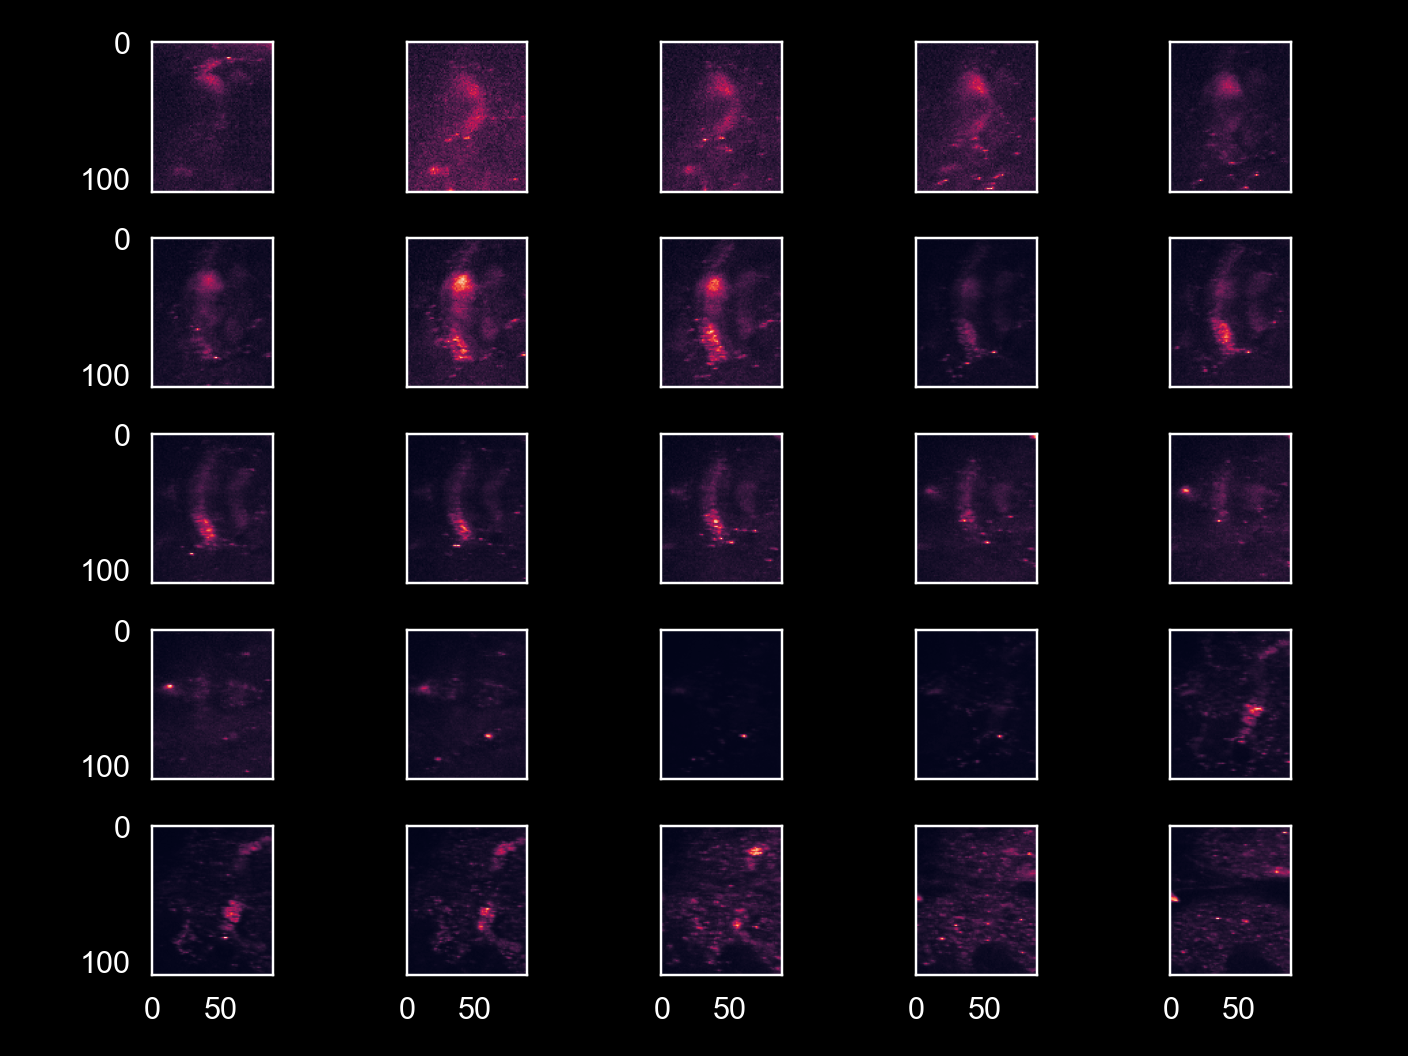

In [79]:
fig, axn = pl.subplots(5,5, sharex=True, sharey=True)
for ax, ai in zip(axn.flat, range(nslices)):
    ax.imshow(avg1[ai, :, :])
pl.tight_layout()

In [80]:
save_dir = os.path.join(dst_dir, os.path.split(anat_src)[-1])
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
print(save_dir)


/Volumes/Julie/plume-tracking/20221102/processed/TSeries-11022022-1740_hdc-split-sytGCaMP7f-60D05_fly3_anatomical-001


In [82]:
outfn = os.path.join(save_dir, 'average_stack.tif')
tf.imwrite(outfn, avg1)

In [74]:
avg.shape

(110, 89, 25)

## Look at 1

In [45]:
file_ix = 0
file_info = filedict[file_ix]
ftpath = file_info['ft_fpath']
imdir = file_info['image_dir']

In [46]:
#print(fpath, air_only)
exp, date_str, fly_id, cond = butil.parse_info_from_file(ftpath)
print(date_str, fly_id, cond)
df0 = butil.load_dataframe(ftpath, mfc_id=None, verbose=False, cond=cond)

11022022-174454 fly3 hdc-sytgcamp7f


In [47]:
#odor_cond = 'hdc-sytgcamp7f'
odor_width=10
grid_sep=200
# get odor border for each fly
ogrid = butil.get_odor_grid(df0, 
                    odor_width=odor_width, grid_sep=grid_sep,
                    use_crossings=True, verbose=False)
ogrid
odor_bounds = list(ogrid.values())
ogrid

Crossings? True


{'c4464': (-3.30315865592591, 6.7012158175868874)}

<IPython.core.display.Javascript object>


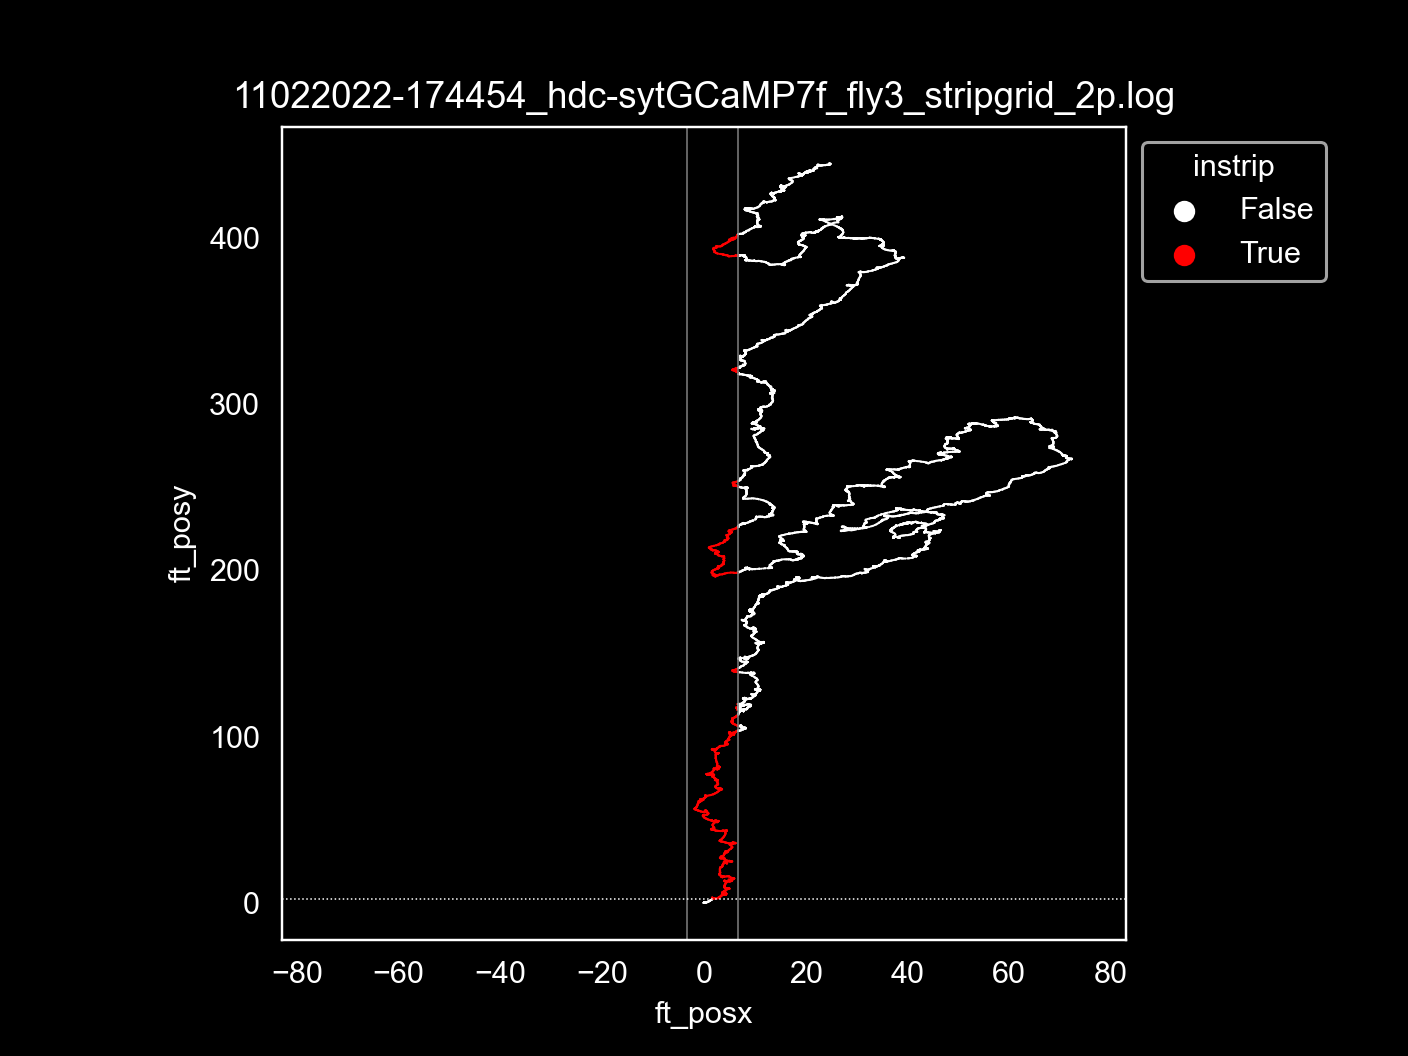

Text(0.5, 1.0, '11022022-174454_hdc-sytGCaMP7f_fly3_stripgrid_2p.log')

In [50]:
fig, ax= pl.subplots()
butil.plot_trajectory(df0, odor_bounds=odor_bounds, ax=ax)
ax.set_title(os.path.split(ftpath)[-1])